## Predicción de Desagregación de Robos en Lakendd

Coder: LeninGF
Date: 2023-03-16

Objetivos:

* Predecir la desagregación de validados y seguimiento para un archivo obtenido desde lakendd

In [1]:
import pandas as pd
import os
# file_path_org=os.path.join(os.getcwd(), 'data/raw/requests/REPORTE_DESI_LAKENDD2_RobosAutosVehiculos.csv')
# file_path_org=os.path.join(os.getcwd(), 'data/raw/requests/robos_enero_julio.csv')
file_path_org=os.path.join(os.getcwd(), 'data/raw/requests/REPORTE_DESI_LAKENDD2_RobosSamborondon.csv')
# xtest = pd.read_csv(file_path_org, parse_dates=['f_FECHA_PS'], converters={'d_NDD':str})
# xtest = pd.read_csv(file_path_org, converters={'NDD':str})
xtest = pd.read_csv(file_path_org, converters={'d_NDD':str})
# xtest.rename(columns = {'NDD':'d_NDD'}, inplace=True)
xtest.shape

(14656, 2)

Obteniendo los relatos

In [2]:
import html
from sqlalchemy import text, create_engine
from src.utils import extraer_relato, conectar_sql
conx = conectar_sql()
relatos_siaf = extraer_relato(sql_connection=conx, lista_ndds=list(set(xtest.d_NDD.to_list())))
relatos_siaf.shape

2023-10-23 15:12:17.518999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


conectando con big data database....


AttributeError: 'DataFrame' object has no attribute 'd_NDD'

In [3]:
relatos_siaf.rename(columns={'RELATO':'d_RELATO_SIAF', 'NDD': 'd_NDD'}, inplace=True)

In [4]:
print(xtest.shape)
xtest = pd.merge(xtest, relatos_siaf, on='d_NDD', how='left')
xtest.shape

(454, 44)


(454, 45)

Dando formato al texto

In [5]:
from src.utils import format_crimestory
format_crimestory(relato_label='d_RELATO_SIAF', dataf=xtest)


Contando las palabras

In [6]:
from src.utils import words_qty
words_qty(dataf=xtest, relato_label='d_RELATO_SIAF')

<AxesSubplot: >

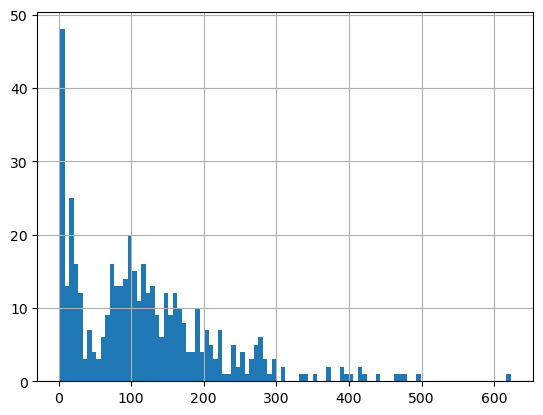

In [7]:
xtest.d_CANTIDAD_PALABRAS.hist(bins=100)

<AxesSubplot: >

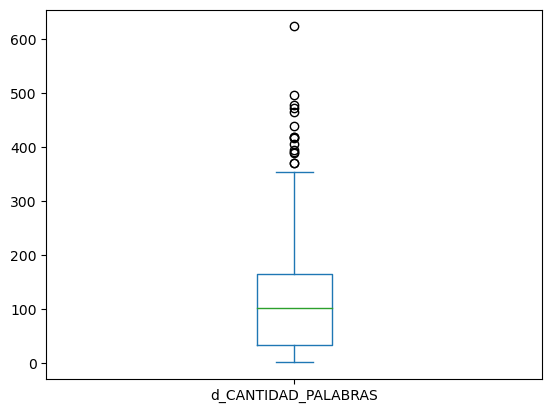

In [8]:
xtest.d_CANTIDAD_PALABRAS.plot.box()

In [9]:
xtest.d_CANTIDAD_PALABRAS.describe().transpose()

count    454.000000
mean     119.264317
std       99.189233
min        2.000000
25%       33.750000
50%      103.000000
75%      164.750000
max      623.000000
Name: d_CANTIDAD_PALABRAS, dtype: float64

In [10]:
# xtest.to_csv('data/interim/delitosRobosAutosconRelato.csv')
# xtest.to_csv('data/interim/delitosRobosLaDefensaEspaciosAcuaticos.csv')

## Cargando Modelo de Machine Learning

In [10]:
from src.utils import load_text_classification_model
PATH_MODEL_SEGUIMIENTOS = '/home/falconiel/ML_Models/robbery_tf20221113'
PATH_MODEL_VALIDADOS = '/home/falconiel/ML_Models/robbery_tf20230213'
model_ckpt = "distilbert-base-multilingual-cased"
SEQ_LEN = 300
THRESHOLD_WORDS_QTY = 50

modelo_delitos_seguimiento = load_text_classification_model(path2model=PATH_MODEL_SEGUIMIENTOS,
                                                            seq_len=SEQ_LEN,
                                                            threshold_words_qty=THRESHOLD_WORDS_QTY)

2023-09-28 09:00:47.059130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 09:00:47.063254: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20221113.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Realizando la predicción sobre el relato de los hechos

In [11]:
from src.utils import predict_text_class
predict_text_class(dataf=xtest,
                    model=modelo_delitos_seguimiento,
                    label_relato='d_RELATO_SIAF',
                    label_name='d_DELITOS_SEGUIMIENTO',
                    words_qty_label='d_CANTIDAD_PALABRAS',
                    threshold_words_qty=THRESHOLD_WORDS_QTY)

In [12]:
modelo_delitos_validados = load_text_classification_model(path2model=PATH_MODEL_VALIDADOS,
                                                            seq_len=SEQ_LEN,
                                                            threshold_words_qty=THRESHOLD_WORDS_QTY)

Some layers from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20230213 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20230213 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from src.utils import predict_text_class
predict_text_class(dataf=xtest,
                    model=modelo_delitos_validados,
                    label_relato='d_RELATO_SIAF',
                    label_name='d_DELITOS_VALIDADOS',
                    words_qty_label='d_CANTIDAD_PALABRAS',
                    threshold_words_qty=THRESHOLD_WORDS_QTY)

In [14]:
xtest["d_CHECK"] = xtest.apply(lambda x: "ok" if x['d_DELITOS_SEGUIMIENTO']==x['d_DELITOS_VALIDADOS'] else "CHECK", axis=1)

In [15]:
xtest.columns

Index(['f_FECHA_PS', 'd_FECHA_US', 'd_NDD', 'd_ANIO_PS', 'd_ANIO_US',
       'd_FECHA_INCIDENTE', 'd_ANIO_INCIDENTE', 'd_MES_PS', 'd_MES_US',
       'd_MES_INCIDENTE', 'd_ARTICULO', 'd_ARTICULO_CIRCUNSTANCIAL',
       'd_DELITO', 'd_DELITO_CIRCUNSTANCIAL', 'd_ESTADO_PROCESAL',
       'd_ETAPA_ACTUAL', 'd_PROVINCIA_US', 'd_PROVINCIA_INCIDENTE',
       'd_CANTON_US', 'd_CANTON_INCIDENTE', 'd_TIPO_DELITO', 'd_ESTADO_NDD',
       'd_DELITO_SECUENCIA', 'd_FECHA_ESTADO_PROCESAL', 'd_EDIFICIO_RECEPCION',
       'd_EDIFICIO_US', 'd_FISCALIA', 'd_NOMBRE_FISCAL', 'd_CEDULA_FISCAL',
       'd_TIPO_FLAGRANTE', 'd_COORDENADAS_INCIDENTE', 'd_PARROQUIA_INCIDENTE',
       'd_BARRIO_INCIDENTE', 'd_ESPECIALIZACION_US', 'd_URB_RURAL_INCIDENTE',
       'd_INVOLUCRADO_APREHENDIDO', 'd_INVOLUCRADO_DESAPARECIDO',
       'd_INVOLUCRADO_DETENIDO', 'd_INVOLUCRADO_FALLECIDO',
       'd_INVOLUCRADO_IMPUTADO', 'd_INVOLUCRADO_PROCESADO',
       'd_INVOLUCRADO_SOSPECHOSO', 'd_INVOLUCRADO_VICTIMA',
       'd_INVOLUCR

In [16]:
xtest[['d_NDD', 'd_CANTIDAD_PALABRAS', 'd_DELITOS_SEGUIMIENTO','d_DELITOS_VALIDADOS']].sample(5)

,d_NDD,d_CANTIDAD_PALABRAS,d_DELITOS_SEGUIMIENTO,d_DELITOS_VALIDADOS
428,091601822020079,42,N/A,N/A
11,091601823080068,110,ROBO A PERSONAS,ROBO A PERSONAS
237,091601822100108,179,ROBO A UNIDADES ECONOMICAS,ROBO A INSTITUCIONES EDUCATIVAS
349,091601822060028,22,N/A,N/A
229,091601822110022,244,ROBO A UNIDADES ECONOMICAS,ROBO A DOMICILIO


In [17]:
xtest.reset_index(inplace=True)
xtest.index

RangeIndex(start=0, stop=454, step=1)

In [18]:
import numpy as np
eval_idx = np.random.randint(xtest.index.start, xtest.index.stop)
print(eval_idx)
print(xtest.d_RELATO_SIAF.iloc[eval_idx])
print(xtest.d_DELITOS_SEGUIMIENTO.iloc[eval_idx], xtest.d_DELITOS_SEGUIMIENTO_SCORE.iloc[eval_idx])

352
señor fiscal el día 07 de abril del 2022 a eso de las 21h00 aproximadamente de las calles olmedo y eloy alfaro sector de la bahía de guayaquil cogí un taxi amarillo conjuntamente con mi hija de 18 años de edad para trasladarme a mi casa en durán en eso yo me he quedado dormido hasta que a la altura de la puntilla se subieron al taxi dos hombres desconocidos para robarnos apuntándonos con armas de fuego uno de ellos con la cacha de la pistola me dio golpes en mi cabeza dejándome inconsciente luego sustrayéndose mi celular samsung a30 recibo de pago del impuesto predial del puesto que yo tengo en la bahía recibo de pago de la credencial de trabajo y la tabla de amortización que me dio en la cooperativa de ahorro y crédito los andes latinos por un crédito que yo saqué hace pocos días asimismo se llevó dos teléfonos celulares de mi hija uno era samsung a51 y el otro ipod 8 también su cédula de ciudadanía papeleta de votación libre de ahorro de la cooperativa fernando daquilema tarjeta 

In [19]:
output_name = file_path_org.split('/')[-1].split('.')[0]+'_Predicted.csv'
xtest.to_csv('data/processed/'+output_name, index=False)

In [20]:
output_name

'REPORTE_DESI_LAKENDD2_RobosSamborondon_Predicted.csv'